In [20]:
# Import libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy
import numpy as np
from sklearn import preprocessing
import math
import numpy as np 
import seaborn as sns
%matplotlib inline
import xgboost as xgb
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
# Specify relative path
url = './yelp_dataset/'

# Convert JSON to pandas DataFrame
data = pd.read_json(url + 'business.json', lines=True)

# Filter data by business of interest: Restaurants 
    # restaurants_filter = data[data['categories'].str.contains("Restaurants") == True]

# Display First 5 instances of the data
data.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [24]:
# Get the review dataset
import ijson
from timeit import default_timer as timer
import datetime

def cleanDataSet(file):
    startTime = timer()
    
    fileName = file + ".json"
    lastline = None
    with open(fileName,"r", encoding="utf-8") as f:
        lineList = f.readlines()
        lastline=lineList[-1]

    with open(fileName,"r", encoding="utf-8") as f, open(file+"Clean.json","w", encoding="utf-8") as g:
        for i,line in enumerate(f,0):
            if i == 0:
                line = "["+str(line)+","
                g.write(line)
            elif line == lastline:            
                g.write(line)
                g.write("]")
            else:
                line = str(line)+","
                g.write(line)
                
    print(f"**** FINISHED CLEANING {fileName} ****")
    
cleanDataSet("yelp_dataset/review")

reviewIds = []
userIds = []
businessIds = []
stars = []
useful = []
funny = []
cool = []
date = []

start = timer()
with open('yelp_dataset/reviewClean.json', encoding="utf-8") as file:
    parser = ijson.parse(file)
    for prefix, event, value in parser:
        if prefix == "item.review_id":
            reviewIds.append(value)
        elif prefix == "item.user_id":
            userIds.append(value)
        elif prefix == "item.business_id":
            businessIds.append(value)
        elif prefix == "item.stars":
            stars.append(value)
        elif prefix == "item.useful":
            useful.append(value)
        elif prefix == "item.funny":
            funny.append(value)
        elif prefix == "item.cool":
            cool.append(value)
        elif prefix == "item.date":
            d = value
            date.append(datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S"))

end = timer()
print(f"*** FINISHED READING DATASET IN {end - start} SECONDS ***")

reviewDf = {
    "Review Id" : reviewIds,
    "User Id" : userIds,
    "Business Id" : businessIds,
    "Stars" : stars,
    "Useful" : useful,
    "Funny" : funny,
    "Cool" : cool,
    "Date" : date
}

reviewDf = pd.DataFrame(reviewDf)
reviewDf.head()

**** FINISHED CLEANING yelp_dataset/review.json ****


NameError: name 'datetime' is not defined

In [ ]:
# Save review dataframe to csv
reviewDf.to_csv("yelp_dataset/yelp_review.csv")

In [26]:
# Read the review data 
review = pd.read_csv('yelp_dataset/yelp_review.csv')

# Group by business
review_busines = review.groupby(by='business_id')

# Extract some features of the grouped dataframe to another
review_businesid = pd.DataFrame()
review_businesid['Mean'] = review_busines['stars'].mean()
review_businesid['Median'] = review_busines['stars'].median()
review_businesid['NumberOfReviews'] = review_busines['stars'].count()

In [27]:
# Read the checkin data
checkin = pd.read_csv("yelp_dataset/yelp_checkin.csv")

# Group by business
checkin_bus = checkin.groupby(by='business_id')

# Extract some features of the grouped dataframe to another
checkin_busid = pd.DataFrame()
checkin_busid['TotalCheckins'] = checkin_bus['checkins'].sum()

# Reset index f 
checkin_busid.reset_index(inplace=True)
review_businesid.reset_index(inplace=True)

# Merge partial dataframes
review_businesid = pd.merge(left=review_businesid,right=checkin_busid,on='business_id', how='left')

# Merge them with the original dataframe
data = pd.merge(left=data,right=review_businesid,on='business_id',how='left')

In [28]:
# Get descriptive stats of the data
description = data.describe()
description

,is_open,latitude,longitude,review_count,stars,Mean,Median,NumberOfReviews,TotalCheckins
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000,159490.000000,159490.000000,159490.000000,136286.000000
mean,0.823040,38.541803,-97.594785,33.538962,3.585627,3.609467,3.788532,32.047495,120.121993
std,0.381635,4.941964,16.697725,110.135224,1.018458,0.996605,1.342712,102.329746,727.676340
min,0.000000,33.204642,-115.493471,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,33.637408,-112.274677,4.000000,3.000000,3.000000,3.000000,4.000000,5.000000
50%,1.000000,36.144815,-111.759323,9.000000,3.500000,3.681818,4.000000,9.000000,18.000000
75%,1.000000,43.602989,-79.983614,25.000000,4.500000,4.379310,5.000000,25.000000,68.000000
max,1.000000,51.299943,-72.911982,8348.000000,5.000000,5.000000,5.000000,7362.000000,131958.000000


In [31]:
# Selecting numerical columns for independent variables of the model
X_columns = ['stars',
              'review_count',
              'Mean',
              'Median',
              'NumberOfReviews',
              'TotalCheckins']

In [42]:
# Slicing dataframe into dependent variable and independent variables
X = data[X_columns]
y = data['is_open']

# Fill missing data with zeros
X = X.fillna(0.0)

In [43]:
# Spliting dataset into training set and test set
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [44]:
# Define a XGBoost model for predict closure of a business
# fit model no training data
model = xgb.XGBClassifier()
model.fit(train_X, train_y)

# make predictions for test data
y_pred = model.predict(test_X)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.32%


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

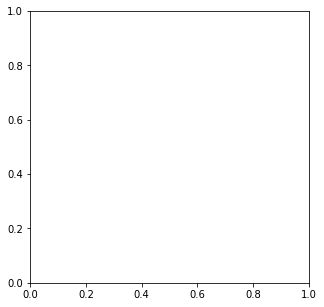

In [49]:
import os
import graphviz
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

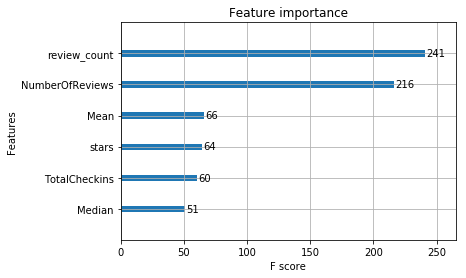

In [48]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [50]:
checkin.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1
